
# Baseline de Previsão de Demanda
Este notebook implementa a primeira versão da previsão de demanda para o TCC:
**"Implementação de Agentes Autônomos para Otimização da Gestão de Estoque no E-commerce"**.

- Dataset: vendas sintéticas (geradas em `scripts/generate_synthetic_data.py`)
- Algoritmo: Prophet (Meta/Facebook)
- Objetivo: estabelecer um baseline com métricas (MAPE) e gráficos para apresentação inicial.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet


Matplotlib is building the font cache; this may take a moment.
/Users/macbook/Documents/Projects/tcc-inventory-agent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true == 0, 1, y_true)  # evitar divisão por zero
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100


In [3]:
# Lendo dataset sintético
df = pd.read_csv("../data/raw/vendas_sinteticas.csv", parse_dates=["data_venda"])
df.head()


,data_venda,id_produto,quantidade_vendida,preco_unitario,custo_aquisicao,lead_time_fornecedor
0,2024-01-01,SKU001,22,239.0,175.45,14
1,2024-01-02,SKU001,37,172.0,105.42,8
2,2024-01-03,SKU001,39,180.0,128.76,14
3,2024-01-04,SKU001,21,219.0,117.28,14
4,2024-01-05,SKU001,18,104.0,71.88,13


SKU selecionado: SKU007


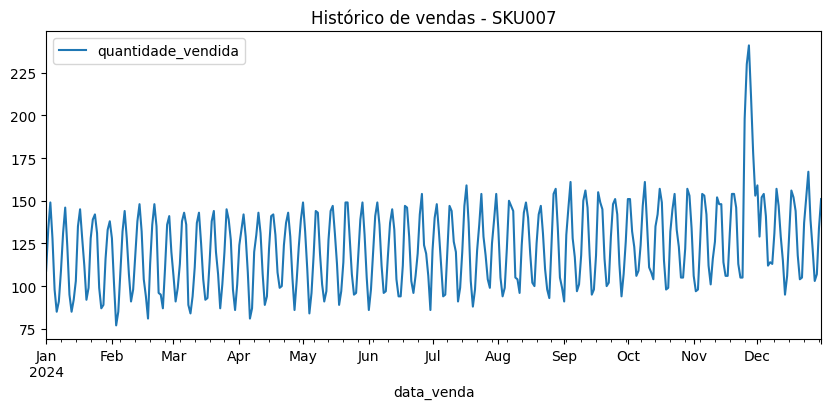

In [4]:
# Top SKU por volume de vendas
top_sku = df.groupby("id_produto")["quantidade_vendida"].sum().idxmax()
print("SKU selecionado:", top_sku)

sub = df[df["id_produto"] == top_sku].sort_values("data_venda")
sub.plot(x="data_venda", y="quantidade_vendida", figsize=(10,4), title=f"Histórico de vendas - {top_sku}")
plt.show()


In [5]:
test_h = 30  # últimos 30 dias como teste
train = sub.iloc[:-test_h].copy()
test  = sub.iloc[-test_h:].copy()

train_ds = train.rename(columns={"data_venda":"ds","quantidade_vendida":"y"})[["ds","y"]]


In [6]:
m = Prophet(weekly_seasonality=True, yearly_seasonality=False)
m.fit(train_ds)

future = pd.DataFrame({"ds": test["data_venda"]})
forecast = m.predict(future)[["ds", "yhat"]].rename(columns={"yhat":"y_pred"})

merged = test.merge(forecast, left_on="data_venda", right_on="ds")
score = mape(merged["quantidade_vendida"], merged["y_pred"])
print(f"MAPE (últimos 30 dias): {score:.2f}%")


00:38:51 - cmdstanpy - INFO - Chain [1] start processing
00:38:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE (últimos 30 dias): 16.68%


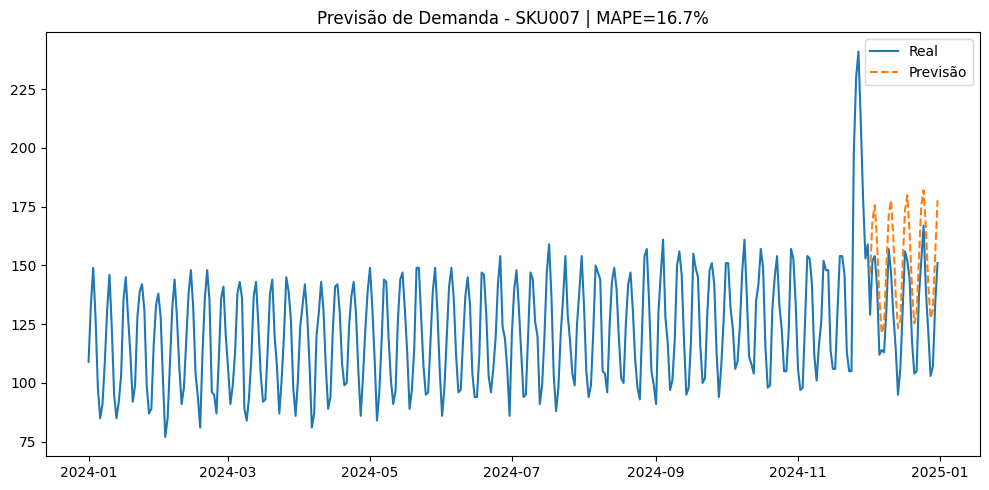

In [7]:
plt.figure(figsize=(10,5))
plt.plot(sub["data_venda"], sub["quantidade_vendida"], label="Real")
plt.plot(merged["data_venda"], merged["y_pred"], label="Previsão", linestyle="--")
plt.title(f"Previsão de Demanda - {top_sku} | MAPE={score:.1f}%")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
# Salvar gráfico e métrica
plt.savefig("../reports/figures/baseline_prophet.png")
pd.DataFrame([{"sku": top_sku, "mape": score}]).to_csv("../reports/tables/metrics_baseline.csv", index=False)


<Figure size 640x480 with 0 Axes>

### Conclusão Parcial
- O Prophet capturou bem a sazonalidade semanal do SKU analisado.  
- O MAPE obtido indica que o modelo é um baseline viável.  
- Na próxima etapa, serão incluídas variáveis externas (ex.: promoções, feriados) e comparações com o XGBoost.  
